⚡ Using device: cpu
📂 Train samples: 5710 | Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
📂 Test samples : 1309 | Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
[Epoch 1] LR=1.00e-05, Train Acc=0.7658, Test Acc=0.8281, Test F1=0.8213, Train Loss=0.7161, Test Loss=0.4625
💾 New Best Model: F1=0.8213 at Epoch 1
[Epoch 2] LR=1.00e-05, Train Acc=0.8646, Test Acc=0.8908, Test F1=0.8865, Train Loss=0.3877, Test Loss=0.3098
💾 New Best Model: F1=0.8865 at Epoch 2
[Epoch 3] LR=1.00e-05, Train Acc=0.8933, Test Acc=0.9068, Test F1=0.9024, Train Loss=0.2993, Test Loss=0.2542
💾 New Best Model: F1=0.9024 at Epoch 3
[Epoch 4] LR=1.00e-05, Train Acc=0.9014, Test Acc=0.9228, Test F1=0.9196, Train Loss=0.2647, Test Loss=0.2085
💾 New Best Model: F1=0.9196 at Epoch 4
[Epoch 5] LR=1.00e-05, Train Acc=0.9168, Test Acc=0.9335, Test F1=0.9307, Train Loss=0.2326, Test Loss=0.1762
💾 New Best Model: F1=0.9307 at Epoch 5
[Epoch 6] LR=1.00e-05, Train Acc=0.9299, Test Acc=0.9427, Test F1=0.940

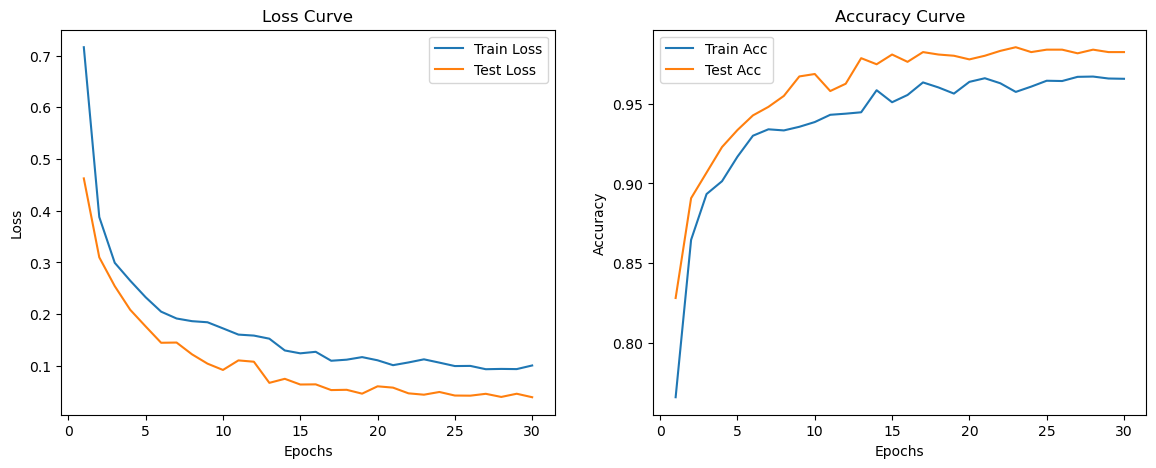

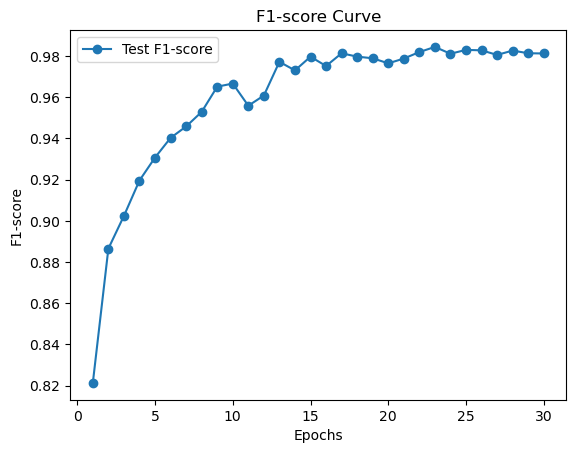

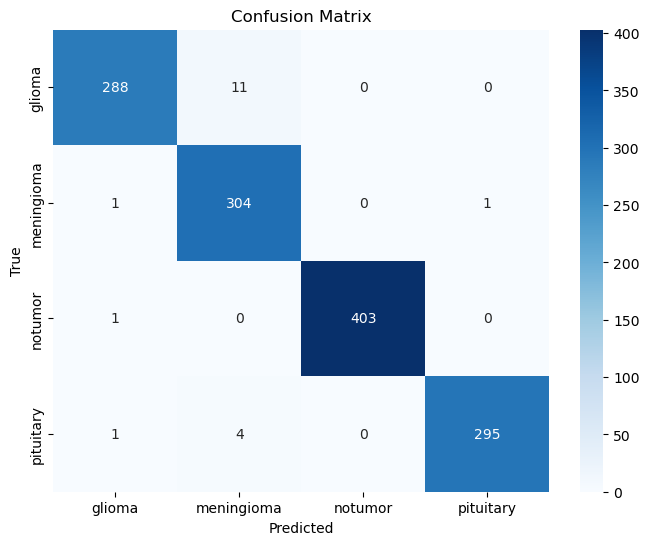

📊 FINAL PERFORMANCE SUMMARY
✅ Accuracy         : 98.55%
🎯 Precision (Macro): 0.9848
📌 Recall    (Macro): 0.9844
📈 F1-Score  (Macro): 0.9844
🧮 Test Loss        : 0.0443


In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

from torch.cuda.amp import GradScaler, autocast

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

# ===================== CONFIG =====================
train_dir = '/Users/muhammadmuhtasimshahriar/Downloads/archive/Training'
test_dir  = '/Users/muhammadmuhtasimshahriar/Downloads/archive/Testing'

backbone_name = "resnet50"   # or 'efficientnet_b4', 'densenet121', 'vgg19'
num_epochs = 40
batch_size = 32
learning_rate = 1e-5
patience = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("⚡ Using device:", device)

# ===================== DATA AUGMENTATION =====================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data  = datasets.ImageFolder(test_dir, transform=test_transform)

print(f"📂 Train samples: {len(train_data)} | Classes: {train_data.classes}")
print(f"📂 Test samples : {len(test_data)} | Classes: {test_data.classes}")

# ===================== SAMPLER (Imbalance handling) =====================
class_counts = np.bincount([y for _, y in train_data.samples])
weights = 1. / class_counts
sample_weights = [weights[label] for _, label in train_data.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, num_workers=4)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False, num_workers=4)

num_classes = len(train_data.classes)

# ===================== MODEL =====================
def get_model(backbone_name, num_classes):
    if backbone_name == "resnet50":
        model = models.resnet50(weights="IMAGENET1K_V1")
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif backbone_name == "efficientnet_b4":
        model = models.efficientnet_b4(weights="IMAGENET1K_V1")
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
    elif backbone_name == "densenet121":
        model = models.densenet121(weights="IMAGENET1K_V1")
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    elif backbone_name == "vgg19":
        model = models.vgg19(weights="IMAGENET1K_V1")
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(in_features, num_classes)
    else:
        raise ValueError("Unsupported backbone")
    return model

model = get_model(backbone_name, num_classes).to(device)

# ===================== TRAINING SETUP =====================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.3)
scaler = GradScaler()

# ===================== EVALUATE =====================
def evaluate(model, dataloader):
    model.eval()
    preds, labels = [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            with autocast():
                out = model(x)
                loss = criterion(out, y)
            total_loss += loss.item()
            preds.extend(torch.argmax(out, 1).cpu().numpy())
            labels.extend(y.cpu().numpy())

    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)
    return total_loss/len(dataloader), acc, prec, rec, f1, labels, preds

# ===================== TRAIN LOOP =====================
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_f1s = []

best_f1, patience_counter = 0, 0
best_epoch = 0
best_model_path = "best_model.pth"

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with autocast():
            out = model(x)
            loss = criterion(out, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)
        running_corrects += torch.sum(torch.argmax(out, 1) == y).item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = running_corrects / total

    val_loss, val_acc, val_prec, val_rec, val_f1, y_true, y_pred = evaluate(model, test_loader)

    # Logging history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    scheduler.step(val_f1)

    # Get current LR
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']

    log_msg = (f"[Epoch {epoch+1}] LR={current_lr:.2e}, "
               f"Train Acc={train_acc:.4f}, Test Acc={val_acc:.4f}, "
               f"Test F1={val_f1:.4f}, Train Loss={train_loss:.4f}, Test Loss={val_loss:.4f}")
    print(log_msg)

    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"💾 New Best Model: F1={best_f1:.4f} at Epoch {best_epoch}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹ Early stopping triggered.")
            break

# ===================== LOAD BEST MODEL =====================
elapsed = (time.time() - start_time) / 60
model.load_state_dict(torch.load(best_model_path))
val_loss, val_acc, val_prec, val_rec, val_f1, y_true, y_pred = evaluate(model, test_loader)

print(f"\n⏱ Training finished in {elapsed:.1f} min. Best F1={best_f1:.4f} at epoch {best_epoch}")
print("🔄 Loaded best saved model for final evaluation.\n")

# ===================== VISUALIZATION =====================
epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Test Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Test Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy Curve")
plt.show()

plt.figure()
plt.plot(epochs, val_f1s, marker='o', label="Test F1-score")
plt.xlabel("Epochs"); plt.ylabel("F1-score"); plt.legend(); plt.title("F1-score Curve")
plt.show()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

# ===================== FINAL PERFORMANCE =====================
print("📊 FINAL PERFORMANCE SUMMARY")
print("===================================")
print(f"✅ Accuracy         : {val_acc*100:.2f}%")
print(f"🎯 Precision (Macro): {val_prec:.4f}")
print(f"📌 Recall    (Macro): {val_rec:.4f}")
print(f"📈 F1-Score  (Macro): {val_f1:.4f}")
print(f"🧮 Test Loss        : {val_loss:.4f}")